### M-LDA

## import data

In [46]:
import pandas as pd
import numpy as np 
import torch
import os
from itertools import chain
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pyro
import pyro.distributions as dist
from pyro.infer import config_enumerate, SVI, TraceEnum_ELBO
from pyro.ops.indexing import Vindex
from pyro.optim import ClippedAdam
from pyro.distributions import constraints
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


experiment_name = "mlda_1.0_10_steps"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Using device: cuda


In [ ]:

experiment_name = "mlda_1.0_10_steps"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)



df = pd.read_csv("data/data_summed.csv")
diagnose_df = pd.read_csv("data/diagnosis.csv", sep=";")


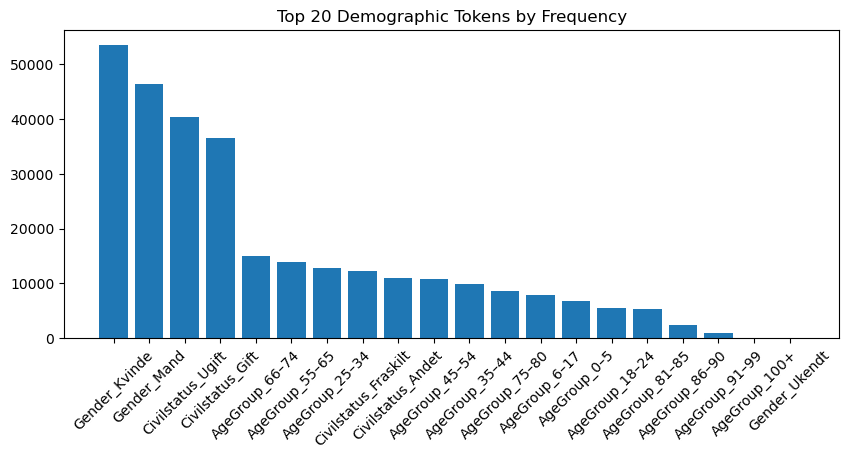

In [62]:
unique_diag_lists = df.groupby("Patient ID")["Aktionsdiagnosekode"].unique()

code = "Aktionsdiagnosekode"
text = "Aktionsdiagnosetekst"
token_dict = {}

for idx, row in diagnose_df.iterrows():
    code_val = row["Aktionsdiagnosekode"]
    text_val = row["Aktionsdiagnosetekst"]
    code_val4 = code_val[:4] if isinstance(code_val, str) and len(code_val) >= 4 else code_val

    text1 = str(code_val4) if pd.notnull(code_val4) else ""
    text2 = str(text_val) if pd.notnull(text_val) else ""
    combined_text = text1 + " " + text2
    token_dict[code_val] = combined_text


# Convert diagnosis codes to full text tokens
diagnosis_per_patient = {
    pid: [token_dict.get(str(code)) for code in codes if str(code) in token_dict]
    for pid, codes in unique_diag_lists.items()
}

age_bins = [0, 5, 18, 25, 35, 45, 55, 65, 75, 80, 85, 90, 99,  float("inf")]
age_labels = [
    "0–5", "6–17", "18–24", "25–34", "35–44", "45–54", "55–65",
    "66–74", "75–80", "81–85", "86–90", "91–99", "100+"
]


df["Age_Group"] = pd.cut(
    df["alder"],
    bins=age_bins,
    labels=age_labels,
    right=True,
    include_lowest=True
)

# Clean and format demographic values
df["gender"] = df["gender"].astype(str).str.strip()
df["civilStand"] = df["civilStand"].astype(str).str.strip()
df["Age_Group"] = df["Age_Group"].astype(str).str.strip()

# Construct context token list
def demographic_tokens(row):
    tokens = []
    if row["gender"]:
        tokens.append(f"Gender_{row['gender']}")
    if row["civilStand"]:
        tokens.append(f"Civilstatus_{row['civilStand']}")
    if row["Age_Group"]:
        tokens.append(f"AgeGroup_{row['Age_Group']}")
    return tokens

df["context"] = df.apply(demographic_tokens, axis=1)

# Drop rows with no context tokens
df = df[df["context"].map(lambda x: len(x) > 0)]

# Group by Patient ID and take the first available context per patient
context_dict = (
    df.groupby("Patient ID")["context"]
    .first()
    .to_dict()
)


# Create patient_df from diagnoses dictionary
patient_df = pd.DataFrame([
    {"patient_id": pid, "diagnoses": diag}
    for pid, diag in diagnosis_per_patient.items()
])

# Create context_df from context_dict
context_df = pd.DataFrame.from_dict(
    {pid: {"context": tokens} for pid, tokens in context_dict.items()},
    orient="index"
)


patient_df["patient_id"] = patient_df["patient_id"].astype(str).str.strip()
context_df.index = context_df.index.astype(str).str.strip()

# Merge into one final dataframe
patient_df = patient_df.set_index("patient_id").join(context_df, how="left").reset_index()

patient_df = patient_df.dropna(subset=["diagnoses", "context"])


# Sample a subset of 100,000 patients for training
patient_df = patient_df.sample(100000, random_state=42)


# visual representation of the top demographic tokens
flat_tokens = [token for row in patient_df["context"] for token in row]
token_counts = Counter(flat_tokens)

top_tokens = token_counts.most_common(20)
tokens, counts = zip(*top_tokens)

plt.figure(figsize=(10, 4))
plt.bar(tokens, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Demographic Tokens by Frequency")
plt.show()

### Create Vocabularies for the model

In [65]:


# Diagnosis vocabulary
diag_vocab = {token: idx for idx, token in enumerate(set(chain.from_iterable(patient_df["diagnoses"])))}

# Context vocabulary
context_vocab = {token: idx for idx, token in enumerate(set(chain.from_iterable(patient_df["context"])))}

# Convert tokens to indices
def tokens_to_indices(tokens, vocab):
    return torch.tensor([vocab[token] for token in tokens if token in vocab], dtype=torch.long)

patient_records_indexed = [tokens_to_indices(tokens, diag_vocab) for tokens in patient_df["diagnoses"]]
context_dict_indexed    = [tokens_to_indices(tokens, context_vocab) for tokens in patient_df["context"]]

# padding and masking

PAD_IDX = 0  

def pad_and_mask(sequences, pad_value=PAD_IDX):
    padded = pad_sequence(sequences, batch_first=True, padding_value=pad_value)
    mask = (padded != pad_value)
    return padded, mask


x_tokens, x_mask = pad_and_mask(patient_records_indexed)
d_tokens, d_mask = pad_and_mask(context_dict_indexed)

# Create dataset and DataLoader
dataset = TensorDataset(x_tokens, d_tokens, x_mask, d_mask)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True, drop_last=True)



### Model

In [ ]:

@config_enumerate(default="parallel")
def model(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device):

    
    x_tokens = x_tokens.to(device)
    d_tokens = d_tokens.to(device)
    x_mask = x_mask.to(device)
    d_mask = d_mask.to(device)

    B, Nx = x_tokens.shape
    _, Nd = d_tokens.shape

    # prior parameters
    alpha = torch.ones(num_groups, device=device) / num_groups 
    beta_x = torch.ones(num_diag_tokens, device=device) / num_diag_tokens
    beta_d = 0.1 * torch.ones(num_demo_tokens, device=device) / num_demo_tokens

    
    # Topic-word distributions (ϕ)
    with pyro.plate("health_groups", num_groups):
        phi_x = pyro.sample("phi_x", dist.Dirichlet(beta_x))
        phi_d = pyro.sample("phi_d", dist.Dirichlet(beta_d))

    # Per-patient topic proportions (θ)
    with pyro.plate("patients", B):
        theta = pyro.sample("theta", dist.Dirichlet(alpha))  # [B, K]

        # DIAGNOSIS TOKENS
        with pyro.plate("x_tokens", Nx):
            z_x = pyro.sample("z_x", dist.Categorical(theta))  # [B, Nx]
            with pyro.poutine.mask(mask=x_mask.permute(1, 0)):  # [Nx, B]
                probs_x = Vindex(phi_x)[z_x]  # [B, Nx, Vx]
                pyro.sample("w_x", dist.Categorical(probs=probs_x), obs=x_tokens.permute(1, 0))  # [Nx, B]

        # DEMOGRAPHIC TOKENS
        with pyro.plate("d_tokens", Nd):
            z_d = pyro.sample("z_d", dist.Categorical(theta))  # [B, Nd]
            with pyro.poutine.mask(mask=d_mask.permute(1, 0)):  # [Nd, B]
                probs_d = Vindex(phi_d)[z_d]  # [B, Nd, Vd]
                pyro.sample("w_d", dist.Categorical(probs=probs_d), obs=d_tokens.permute(1, 0))  # [Nd, B]



In [ ]:


def guide(x_tokens, d_tokens, x_mask, d_mask,
          num_groups, num_diag_tokens, num_demo_tokens,
          device):

    
    x_tokens = x_tokens.to(device)
    d_tokens = d_tokens.to(device)
    x_mask = x_mask.to(device)
    d_mask = d_mask.to(device)

    B = x_tokens.shape[0]

    # Topic-word distributions (ϕ) - global
    phi_x_posterior = pyro.param("phi_x_posterior",
                                 torch.ones(num_groups, num_diag_tokens, device=device),
                                 constraint=constraints.simplex)
    phi_d_posterior = pyro.param("phi_d_posterior",
                                 torch.ones(num_groups, num_demo_tokens, device=device),
                                 constraint=constraints.simplex)

    with pyro.plate("health_groups", num_groups):
        pyro.sample("phi_x", dist.Dirichlet(phi_x_posterior))
        pyro.sample("phi_d", dist.Dirichlet(phi_d_posterior))

    # Patient topic distributions (θ)
    theta_posterior = pyro.param("theta_posterior",
                                 0.1 * torch.ones(B, num_groups, device=device),
                                 constraint=constraints.positive)

    with pyro.plate("patients", B):
        pyro.sample("theta", dist.Dirichlet(theta_posterior))





In [ ]:
pyro.clear_param_store()

optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))


num_groups = 20
num_diag_tokens = len(diag_vocab)
num_demo_tokens = len(context_vocab)
num_steps = 15
losses = []

# Training loop with minibatching
for step in range(num_steps):
    total_loss = 0
    for x_batch, d_batch, x_mask, d_mask in dataloader:

        torch.cuda.empty_cache()

        x_batch = x_batch.to(device)
        d_batch = d_batch.to(device)
        x_mask = x_mask.to(device)
        d_mask = d_mask.to(device)
        loss = svi.step(x_batch, d_batch, x_mask, d_mask,
                        num_groups, num_diag_tokens, num_demo_tokens, device)
        total_loss += loss
        
    losses.append(total_loss)
    torch.cuda.empty_cache()

    print(f"[Step {step}] ELBO Loss: {total_loss:.2f}")

gc.collect()
torch.cuda.empty_cache()

[Step 0] ELBO Loss: 4304112.67
[Step 1] ELBO Loss: 3935625.78
[Step 2] ELBO Loss: 3269053.23
[Step 3] ELBO Loss: 2350954.86
[Step 4] ELBO Loss: 1220636.99
[Step 5] ELBO Loss: -91776.59
[Step 6] ELBO Loss: -1548446.08
[Step 7] ELBO Loss: -3154541.62
[Step 8] ELBO Loss: -4878533.47
[Step 9] ELBO Loss: -6710314.91
[Step 10] ELBO Loss: -8642870.61
[Step 11] ELBO Loss: -10663160.10
[Step 12] ELBO Loss: -12753961.11
[Step 13] ELBO Loss: -14928734.97
[Step 14] ELBO Loss: -17176527.50


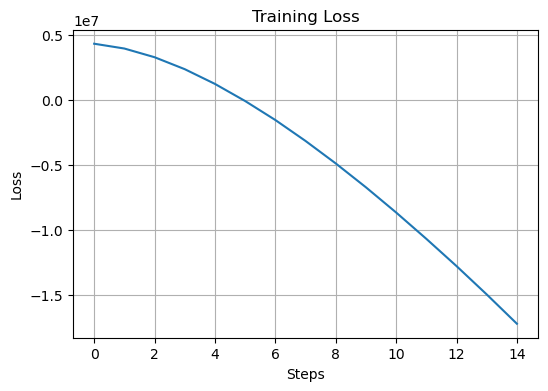

In [ ]:


num_steps = len(losses)

# loss plotting
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    #plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"loss_plot_{num_groups}groups_{10000}samples_{num_steps}steps.pdf"))
    plt.show()


plot_loss(losses)

In [13]:


def save_model(svi, model_path="model_params.pt"):
    """
    Save the model parameters from an SVI object.

    Args:
        svi (pyro.infer.SVI): The SVI object containing the trained model.
        model_path (str): Path to save the model parameters.
    """
    pyro_params = {
        name: pyro.param(name).detach().cpu()
        for name in pyro.get_param_store().keys()
    }
    torch.save(pyro_params, model_path)
    print(f"Model parameters saved to {model_path}")

num_steps = 10  # Number of steps for which the model was trained
model_path = os.path.join(save_dir, f"model_params_{num_steps}.pt")
save_model(svi, model_path=model_path)

Model parameters saved to outputs\mlda_1.0_10_steps\model_params_10.pt


In [35]:


def plot_top_tokens(phi_matrix, vocab_inv, topic_idx, top_k=10, title_prefix="Topic", label="Token"):
    
    topic_dist = phi_matrix[topic_idx]  # [vocab_size]
    topk_indices = torch.topk(topic_dist, top_k).indices
    topk_tokens = [vocab_inv[i.item()] for i in topk_indices]
    topk_probs = topic_dist[topk_indices].detach().cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.barh(topk_tokens[::-1], topk_probs[::-1])
    plt.xlabel("Probability")
    plt.ylabel(label)
    plt.title(f"{title_prefix} {topic_idx} – Top {top_k} {label}s")
    plt.tight_layout()
    plt.show()


In [66]:
def plot_top_demographic_categories(phi_d, inv_context_vocab, topic_idx, title_prefix="Demographic Topic"):
    topic_dist = phi_d[topic_idx].detach().cpu()
    
    # Decode vocabulary
    token_labels = [inv_context_vocab[i] for i in range(len(inv_context_vocab))]
    
    # Split into groups
    gender_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "Gender_" in label]
    age_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "AgeGroup_" in label]
    civil_tokens = [(label, prob) for label, prob in zip(token_labels, topic_dist) if "Civilstatus_" in label]

    # Get most probable token per group
    top_gender = max(gender_tokens, key=lambda x: x[1]) if gender_tokens else ("None", 0.0)
    top_age = max(age_tokens, key=lambda x: x[1]) if age_tokens else ("None", 0.0)
    top_civil = max(civil_tokens, key=lambda x: x[1]) if civil_tokens else ("None", 0.0)

    labels = [top_gender[0], top_civil[0], top_age[0]]
    probs = [top_gender[1], top_civil[1], top_age[1]]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.barh(labels[::-1], [p.item() for p in probs[::-1]])  # Reverse for descending order
    plt.xlabel("Probability")
    plt.title(f"{title_prefix} {topic_idx} – Top Demographic Attributes")
    plt.tight_layout()
    plt.show()

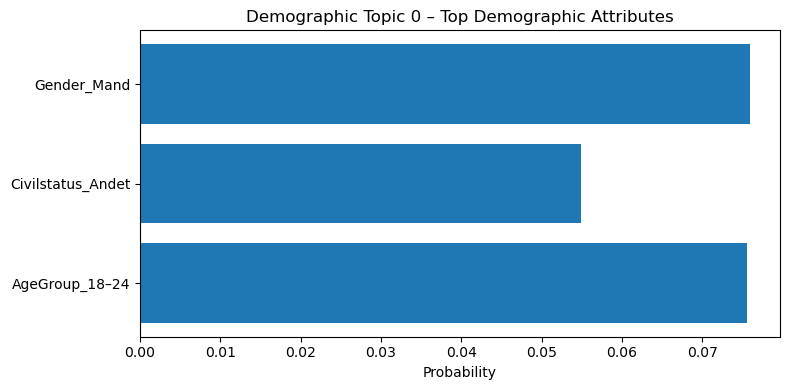

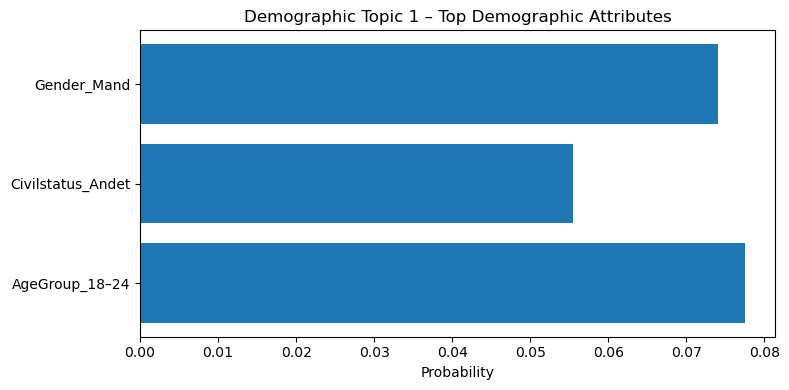

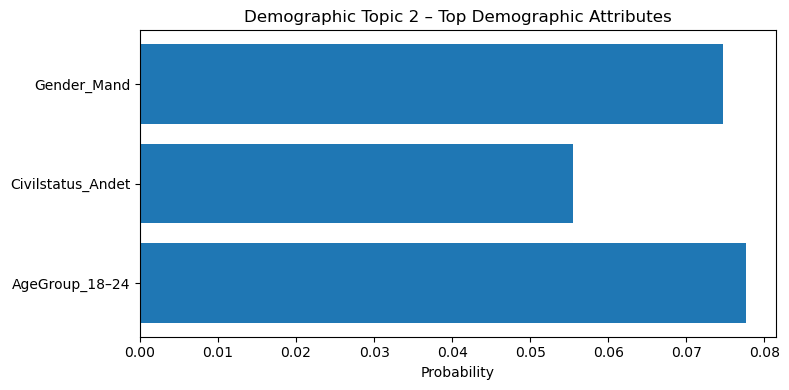

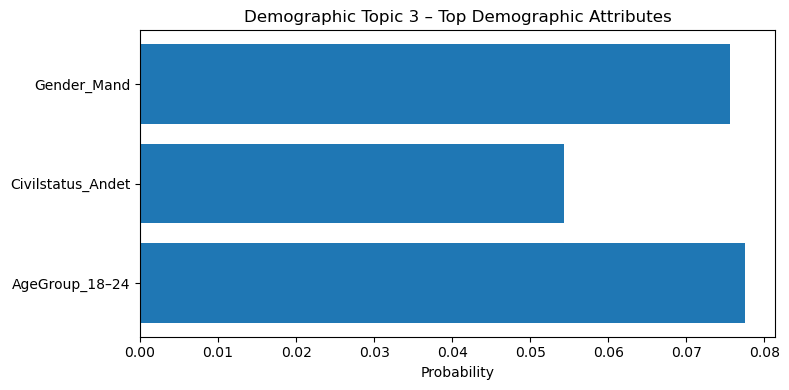

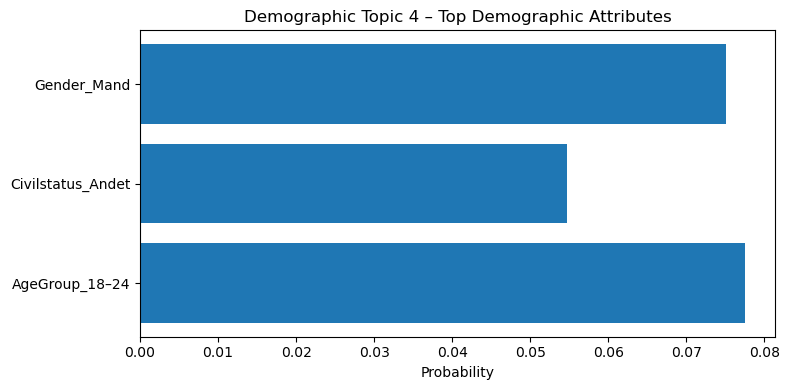

In [67]:
phi_x = pyro.get_param_store().get_param("phi_x_posterior")  
phi_d = pyro.get_param_store().get_param("phi_d_posterior")  

top_k = 7
num_topics_to_plot = 5
inv_context_vocab = {idx: token for token, idx in context_vocab.items()}
for i in range(num_topics_to_plot):
    plot_top_demographic_categories(phi_d, inv_context_vocab,i, title_prefix="Demographic Topic")

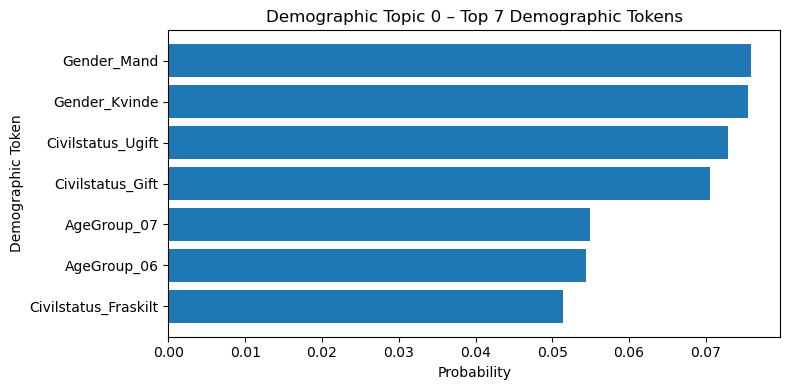

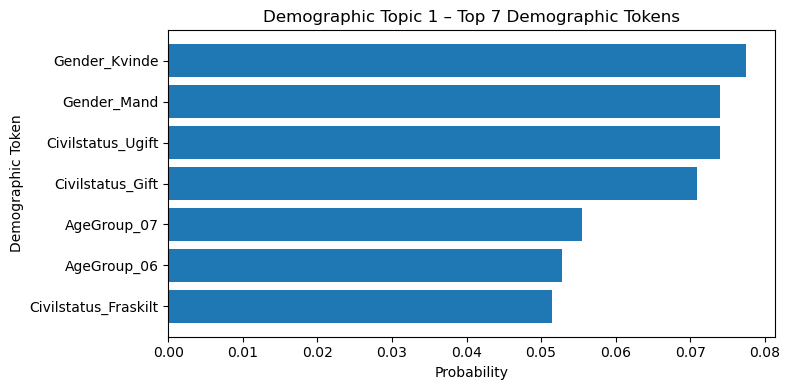

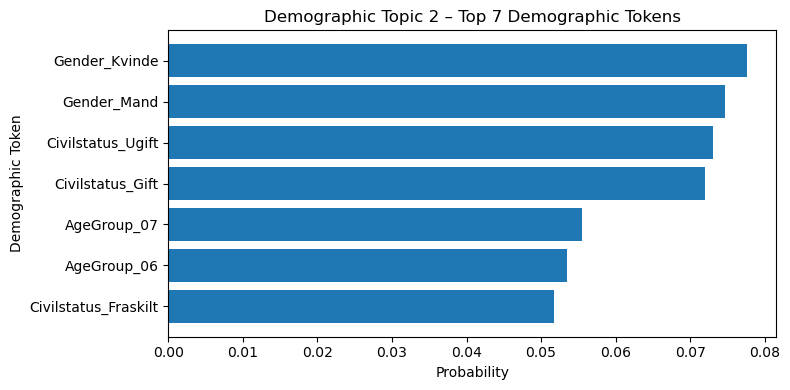

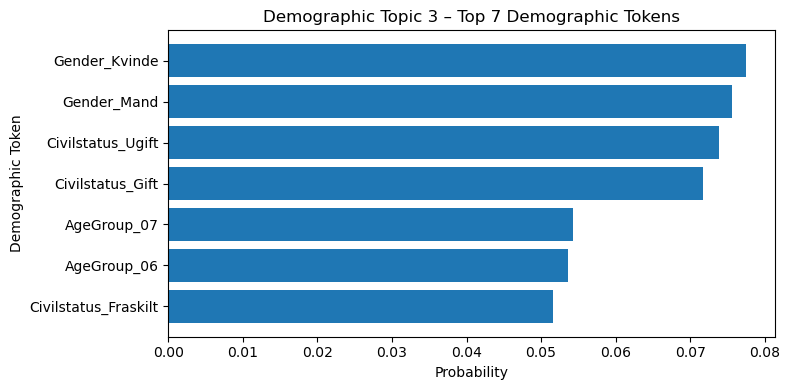

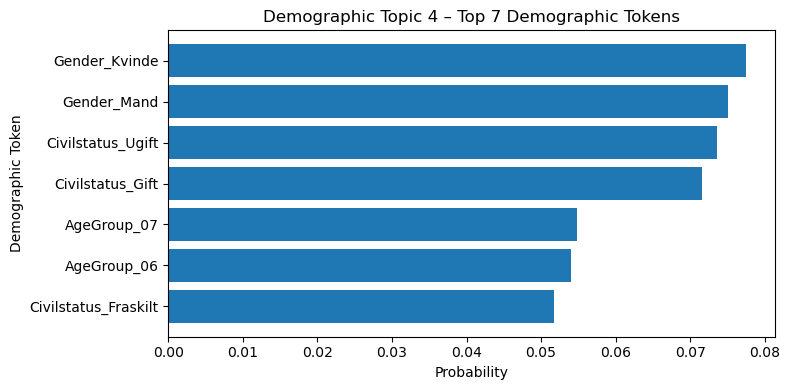

In [ ]:
#load latent parameters
phi_x = pyro.get_param_store().get_param("phi_x_posterior")  
phi_d = pyro.get_param_store().get_param("phi_d_posterior")  

# Invert the vocabulary dictionary
inv_diag_vocab = {idx: token for token, idx in diag_vocab.items()}
inv_context_vocab = {idx: token for token, idx in context_vocab.items()}

# Plot top-k tokens for the first few topics
top_k = 7
num_topics_to_plot = 5
for i in range(num_topics_to_plot):
    plot_top_tokens(phi_d, inv_context_vocab, topic_idx=i, top_k=top_k,
                    title_prefix="Demographic Topic", label="Demographic Token")

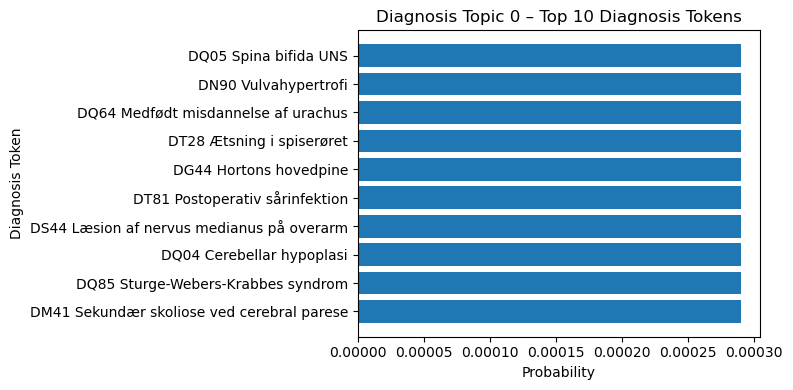

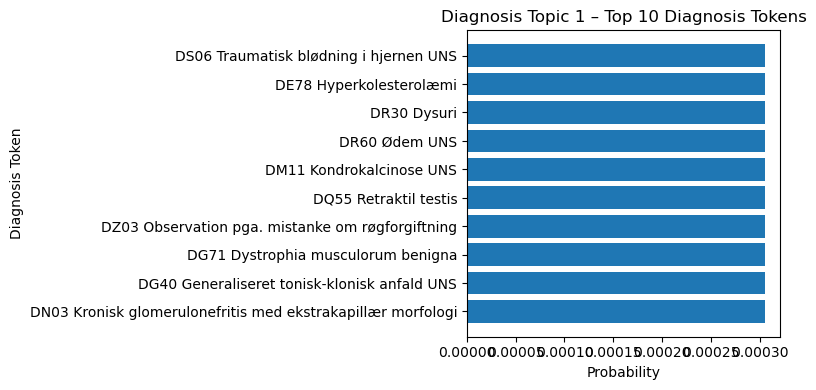

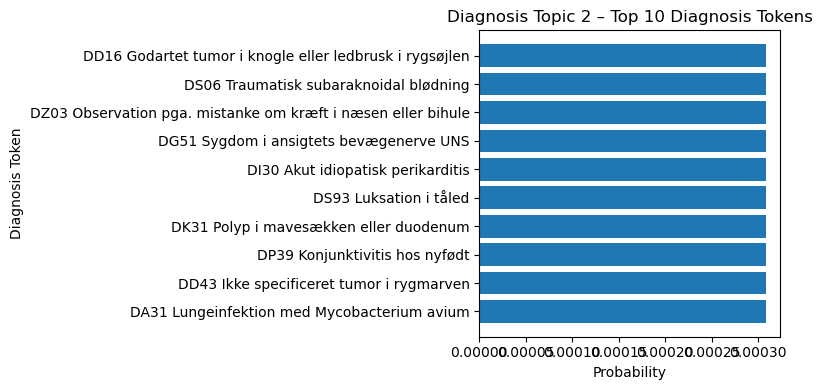

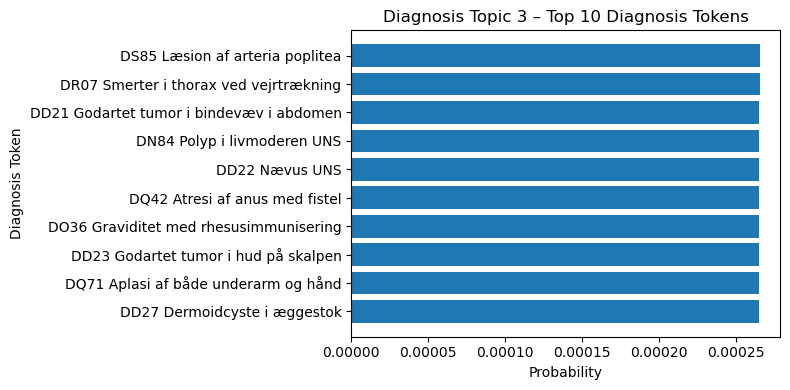

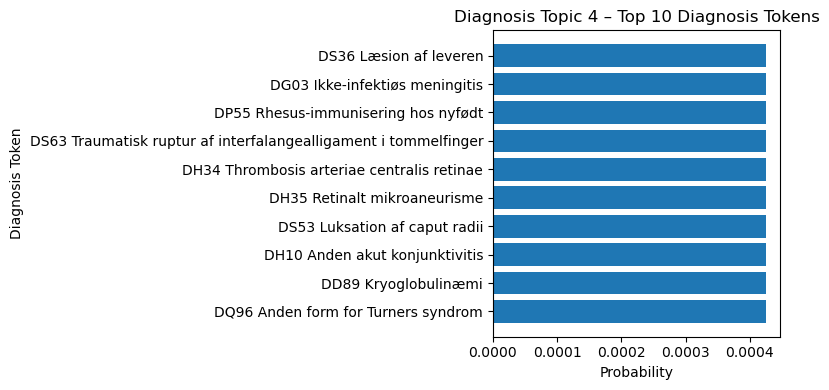

In [42]:
num_topics_to_plot = 5
for i in range(num_topics_to_plot):
    plot_top_tokens(phi_x, inv_diag_vocab, topic_idx=i, top_k=10,
                    title_prefix="Diagnosis Topic", label="Diagnosis Token")

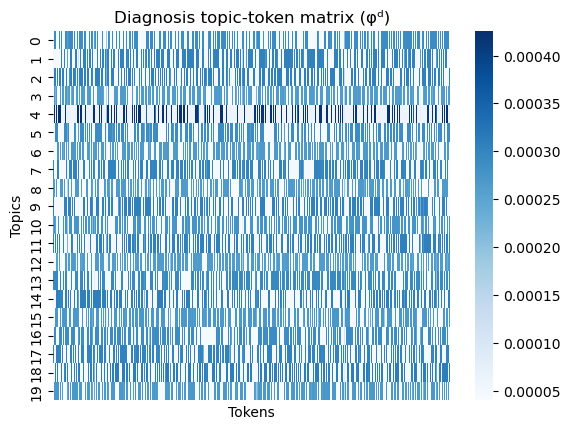

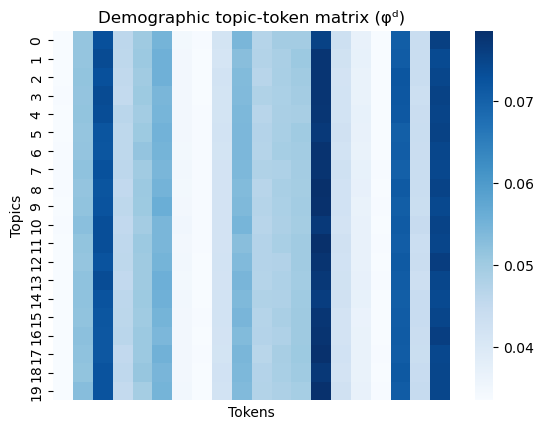

In [60]:

sns.heatmap(phi_x.cpu().detach().numpy(), cmap="Blues", xticklabels=False)
plt.title("Diagnosis topic-token matrix (φᵈ)")
plt.xlabel("Tokens")
plt.ylabel("Topics")
plt.show()

sns.heatmap(phi_d.cpu().detach().numpy(), cmap="Blues", xticklabels=False)
plt.title("Demographic topic-token matrix (φᵈ)")
plt.xlabel("Tokens")
plt.ylabel("Topics")
plt.show()

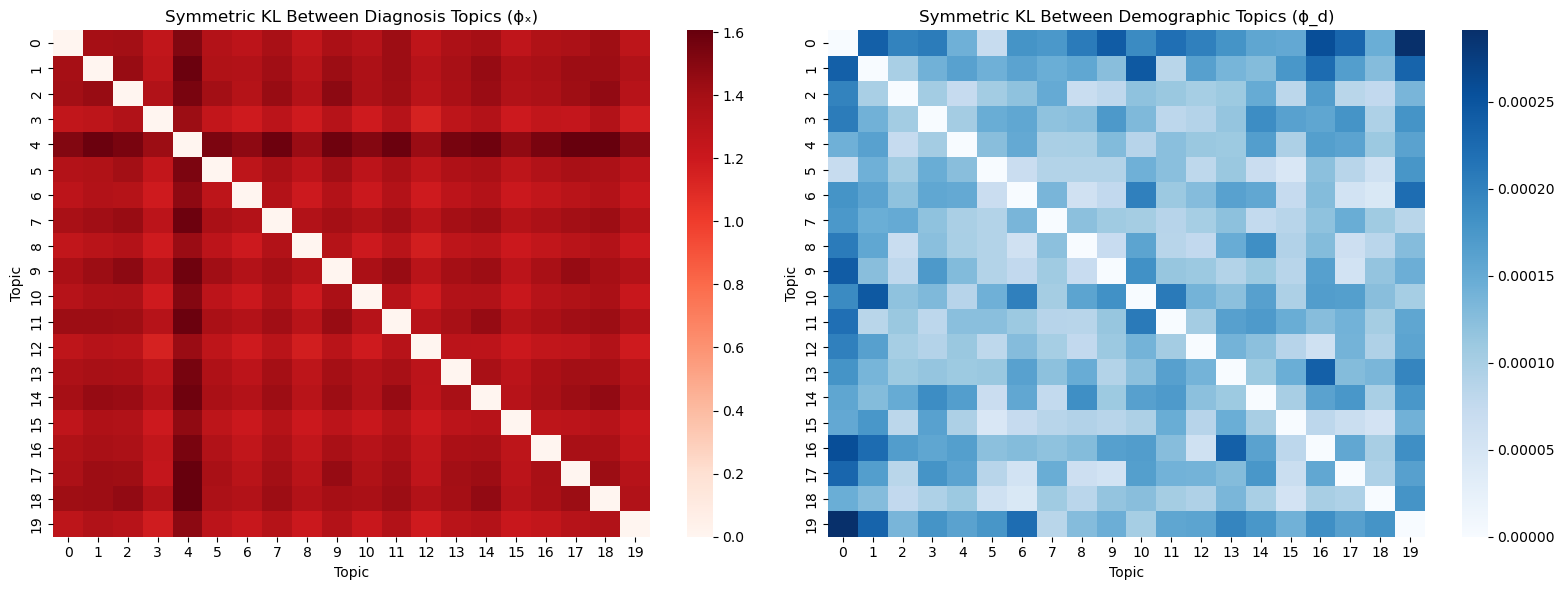

In [55]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

# --- Helper: Symmetric KL Divergence ---
def symmetric_kl(p, q, eps=1e-10):
    p = torch.clamp(p, min=eps)
    q = torch.clamp(q, min=eps)
    p = p / p.sum()
    q = q / q.sum()
    kl_pq = torch.sum(p * torch.log(p / q))
    kl_qp = torch.sum(q * torch.log(q / p))
    return (kl_pq + kl_qp).item()

# --- Extract phi_x and phi_d ---
phi_x = pyro.param("phi_x_posterior").detach().cpu()  # shape: [num_topics, num_diag_tokens]
phi_d = pyro.param("phi_d_posterior").detach().cpu()  # shape: [num_topics, num_demo_tokens]

num_topics = phi_x.shape[0]

# --- Compute Symmetric KL Matrices ---
kl_matrix_x = torch.zeros(num_topics, num_topics)
kl_matrix_d = torch.zeros(num_topics, num_topics)

for i in range(num_topics):
    for j in range(num_topics):
        kl_matrix_x[i, j] = symmetric_kl(phi_x[i], phi_x[j])
        kl_matrix_d[i, j] = symmetric_kl(phi_d[i], phi_d[j])

# --- Plot Heatmaps ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(kl_matrix_x.numpy(), ax=axs[0], cmap="Reds", cbar=True)
axs[0].set_title("Symmetric KL Between Diagnosis Topics (ϕₓ)")
axs[0].set_xlabel("Topic")
axs[0].set_ylabel("Topic")

sns.heatmap(kl_matrix_d.numpy(), ax=axs[1], cmap="Blues", cbar=True)
axs[1].set_title("Symmetric KL Between Demographic Topics (ϕ_d)")
axs[1].set_xlabel("Topic")
axs[1].set_ylabel("Topic")

plt.tight_layout()
plt.show()



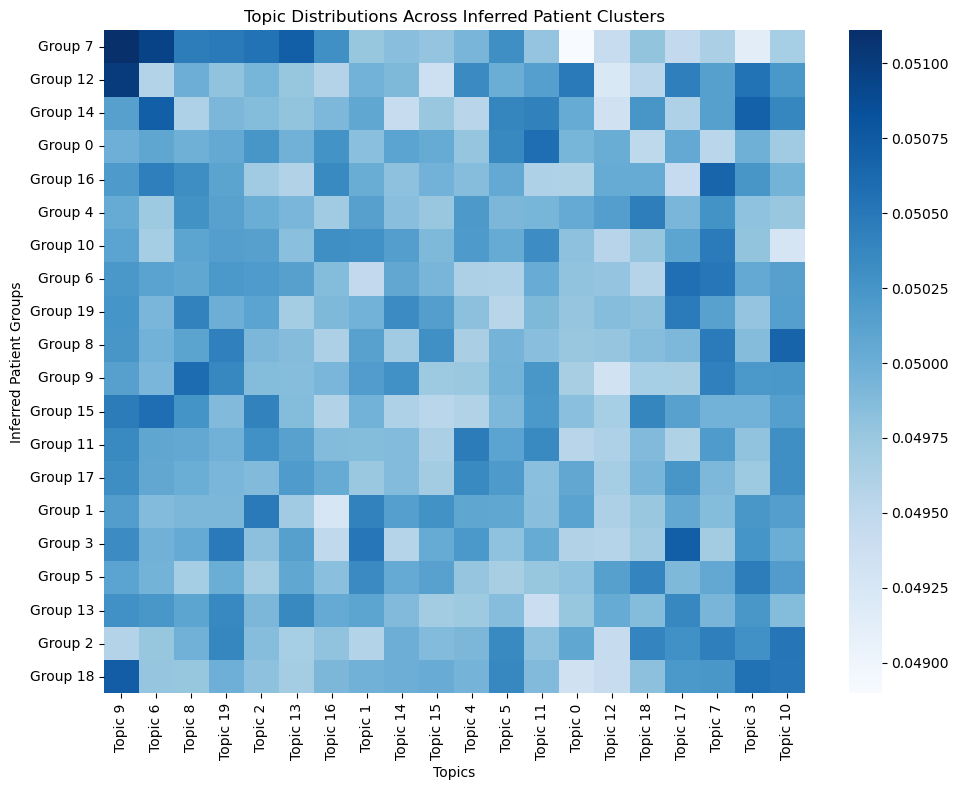

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# --- Assume `heatmap_data` is [num_groups, num_topics] matrix already computed ---

# Hierarchical clustering to reorder rows and columns
row_linkage = linkage(pdist(heatmap_data, metric="euclidean"), method="average")
col_linkage = linkage(pdist(heatmap_data.T, metric="euclidean"), method="average")

row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the matrix
reordered = heatmap_data[row_order][:, col_order]

# Plot without dendrograms
plt.figure(figsize=(10, 8))
sns.heatmap(reordered, cmap="Blues", cbar=True,
            xticklabels=[f"Topic {i}" for i in col_order],
            yticklabels=[f"Group {i}" for i in row_order])
plt.title("Topic Distributions Across Inferred Patient Clusters")
plt.xlabel("Topics")
plt.ylabel("Inferred Patient Groups")
plt.tight_layout()
plt.show()

